In [1]:
import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as transforms
import os
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
import lightning as L


## find the train and test splits

In [2]:
# Load data sets
transform = transforms.ToTensor()
train_set = datasets.MNIST(root="MNIST", download=True, train=True, transform=transform)
test_set = datasets.MNIST(root="MNIST", download=True, train=False, transform=transform)

In [3]:
train_set_size = int(len(train_set)*0.8)
valid_set_size = len(train_set) - train_set_size


seed = torch.Generator().manual_seed(42)
train_set, valid_set = data.random_split(train_set, [train_set_size, valid_set_size],
                                        generator=seed)
print(seed)


In [17]:
a = next(iter(train_set))
image, label = a

In [21]:
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.1098, 0.2627, 0.9490, 0.9961, 1.0000,

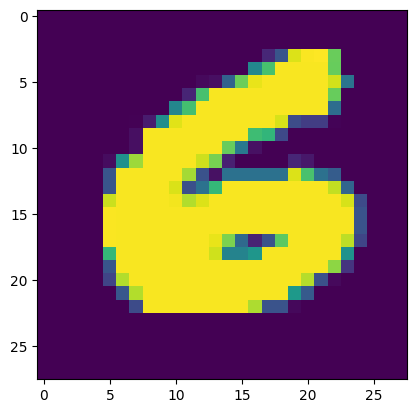

In [20]:
import matplotlib.pyplot as plt
plt.imshow(image[0])

## define the test loop

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(28*28, 64),
                               nn.ReLU(),
                               nn.Linear(64, 3))
    def forward(self, x):
        return self.l1(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(3, 64), 
                               nn.ReLU(),
                               nn.Linear(64, 28*28))
    def forward(self, x):
        return self.l1(x)

In [5]:
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        return loss

    def validation_step(self, batch, batch_idx):
        y, x = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = F.mse_loss(x_hat, x)
        self.log("val_loss", val_loss)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## model

In [6]:
# model
autoencoder = LitAutoEncoder(Encoder(), Decoder())
print(autoencoder)

LitAutoEncoder(
  (encoder): Encoder(
    (l1): Sequential(
      (0): Linear(in_features=784, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (decoder): Decoder(
    (l1): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=784, bias=True)
    )
  )
)


## train with the test loop

In [7]:
train_loader = DataLoader(train_set)
valid_loader = DataLoader(valid_set)


# initialize the Trainer
trainer = L.Trainer(limit_train_batches=256, max_epochs=10 )

trainer.fit(autoencoder, train_loader, valid_loader)

# test the model
trainer.test(model=autoencoder, dataloaders=DataLoader(test_set)) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 50.4 K
1 | decoder | Decoder | 51.2 K
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


RuntimeError: MPS device does not support linear for non-float inputs